In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def load_json(file_path): # Load JSON Data
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print("JSON decode error — file is empty or malformed.")
                return {}
    else:
        return {}  # Return empty dict if file doesn't exist


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

def phase_key_to_short(phase_key):
    """
    Convert 'VO2 (space group 14)' to 'VO2_14'
    """
    if " (space group " in phase_key and phase_key.endswith(")"):
        name, sg = phase_key.split(" (space group ")
        sg = sg.rstrip(")")
        return f"{name} ({sg})"
    return phase_key

# variable init 
json_file_path = "Data/interpretations_llm_v1_llama1.json"
json_file = load_json(json_file_path)

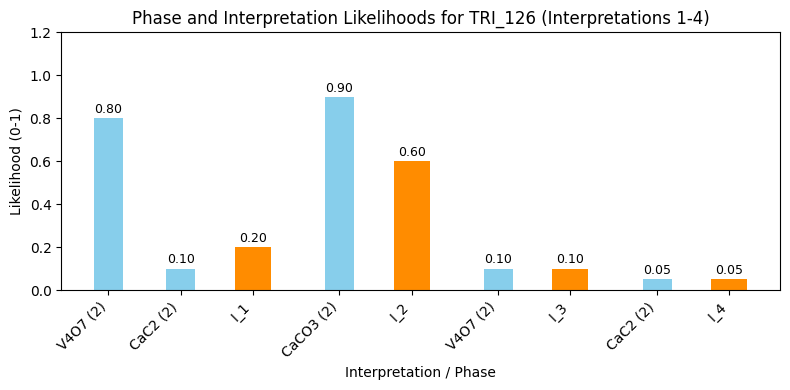

In [233]:

run = "TRI_126"
interpretations = [j for j in json_file[run].keys() if j.startswith("I_")]
n_per_plot = 4
bar_gap = 0.2
for chunk_start in range(0, len(interpretations), n_per_plot):
    bar_labels = []
    bar_values = []
    bar_colors = []
    bar_types = []  # Track if it's a phase or interpretation bar
    bar_positions = []
    position = 0
    chunk = interpretations[chunk_start:chunk_start + n_per_plot]
    for interpretation in chunk:
        llama_phase_list = json_file[run][interpretation]["LLM_phases_likelihood_llama"]
        for phase in llama_phase_list:
            phase_name = phase_key_to_short(phase)
            bar_labels.append(f"{phase_name}")
            bar_values.append(llama_phase_list[phase])
            bar_colors.append("skyblue")
            bar_types.append("phase")
            bar_positions.append(position)
            position += 1
        bar_labels.append(interpretation)
        bar_values.append(json_file[run][interpretation]["LLM_interpretation_likelihood_llama"])
        #bar_values = [i*100 for i in bar_values]
        bar_colors.append("darkorange")
        bar_types.append("interp")
        bar_positions.append(position)
        position += 1 + bar_gap

    plt.figure(figsize=(8, 4))
    # Draw phase bars (thinner)
    phase_indices = [i for i, t in enumerate(bar_types) if t == "phase"]
    plt.bar(
        [bar_positions[i] for i in phase_indices],
        [bar_values[i] for i in phase_indices],
        color=[bar_colors[i] for i in phase_indices],
        width=0.4,
        label="Phase"
    )
    # Draw interpretation bars (wider)
    interp_indices = [i for i, t in enumerate(bar_types) if t == "interp"]
    plt.bar(
        [bar_positions[i] for i in interp_indices],
        [bar_values[i] for i in interp_indices],
        hatch = '',
        color=[bar_colors[i] for i in interp_indices],
        width=0.5,
        label="Interpretation"
    )
    # handles = []
    # handles.append(plt.Rectangle((0,0),1,1, color="skyblue", label="Phases"))
    # handles.append(plt.Rectangle((0,0),1,1, color="darkorange", label="Interpretations"))
    # plt.legend(handles=handles, title="Key", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.ylabel('Likelihood (0-1)')
    plt.xlabel('Interpretation / Phase')
    plt.title(f'Phase and Interpretation Likelihoods for {run} (Interpretations {chunk_start+1}-{chunk_start+len(chunk)})')
    plt.ylim(0, 1.2)
    for j, val in enumerate(bar_values):
        plt.text(bar_positions[j], val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    plt.xticks(bar_positions, bar_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

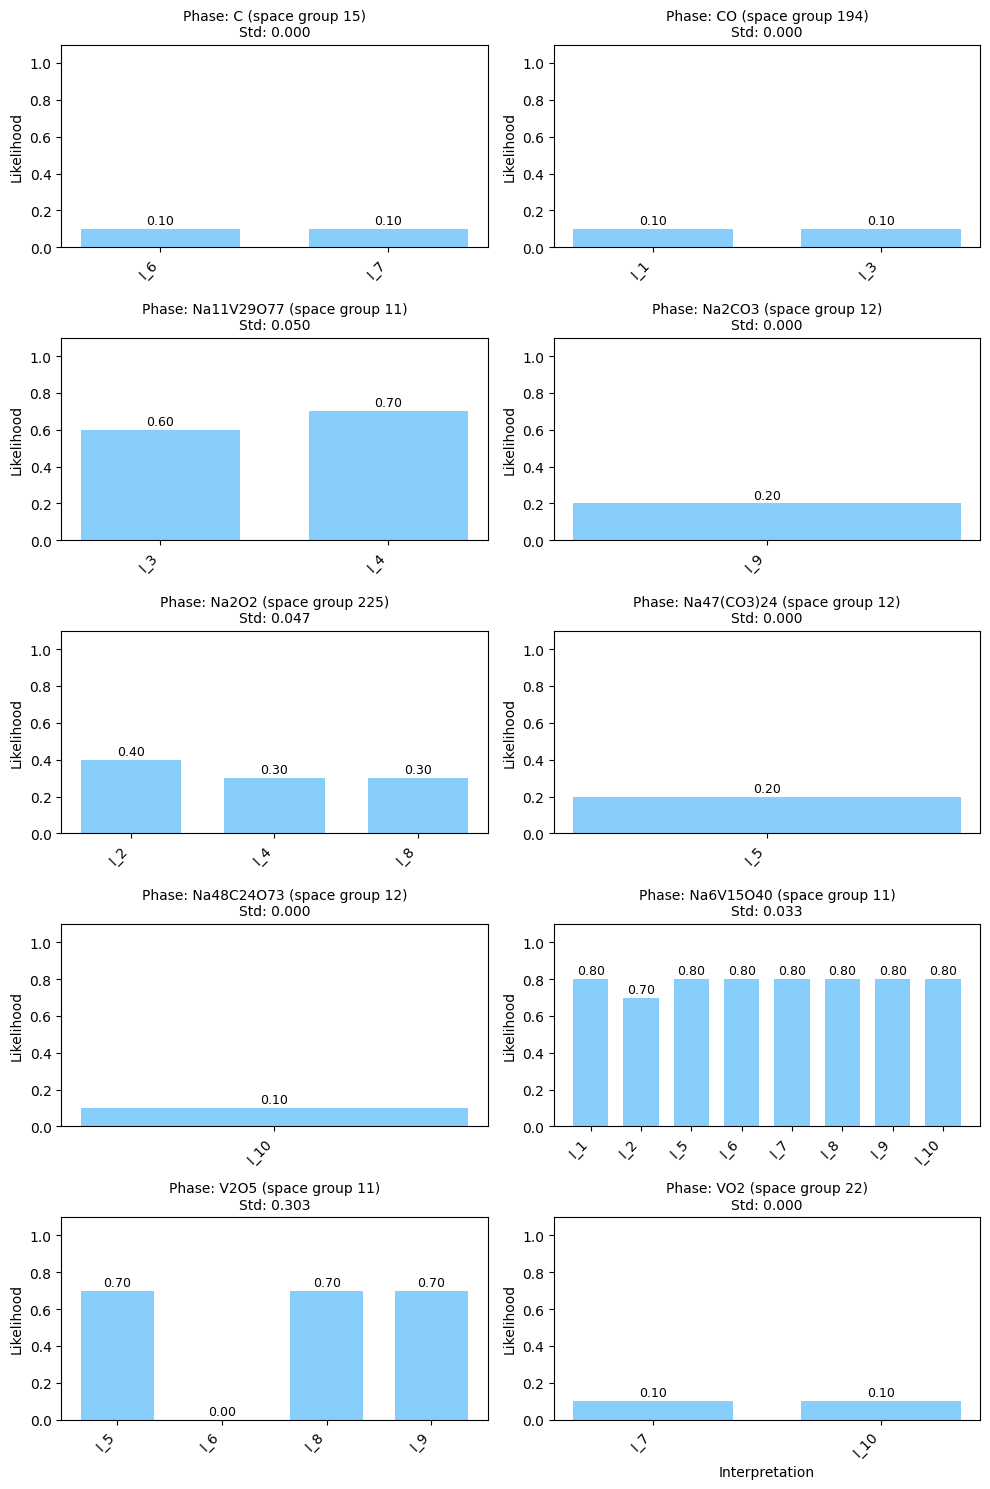

In [331]:
import matplotlib.pyplot as plt
import numpy as np

run = "TRI_181"

# ---- Pick a range of interpretations to process ----
start_idx = 0   # inclusive
end_idx = 10     # exclusive (change as needed)
# ---------------------------------------------------

all_interpretations = [k for k in json_file[run] if k.startswith("I_")]
interpretations = all_interpretations[start_idx:end_idx]

# 1. Collect all unique phase names for the selected interpretations
all_phases = set()
for interpretation in interpretations:
    phase_likelihoods = json_file[run][interpretation].get("LLM_phases_likelihood_llama", {})
    for phase in phase_likelihoods:
        all_phases.add(phase)
all_phases = sorted(all_phases)

# 2. For each phase, collect only interpretations where phase is present
phase_likelihood_matrix = []
phase_interp_labels = []
for phase in all_phases:
    likelihoods = []
    interp_labels = []
    for interp in interpretations:
        phase_likelihoods = json_file[run][interp].get("LLM_phases_likelihood_llama", {})
        value = None
        # Try both long and short keys
        if phase in phase_likelihoods:
            value = phase_likelihoods[phase]
        else:
            for k, v in phase_likelihoods.items():
                if phase_key_to_short(k) == phase:
                    value = v
                    break
        if value is not None:
            likelihoods.append(value)
            interp_labels.append(interp)
    phase_likelihood_matrix.append(likelihoods)
    phase_interp_labels.append(interp_labels)

# 3. Plot: one subplot per phase, x-axis = only interpretations where phase is present
n_phases = len(all_phases)
ncols = 2
nrows = int(np.ceil(n_phases / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3*nrows), sharex=False)
axes = axes.flatten()

if n_phases == 1:
    axes = [axes]

for i, phase in enumerate(all_phases):
    ax = axes[i]
    y = phase_likelihood_matrix[i]
    x_labels = phase_interp_labels[i]
    x = np.arange(len(x_labels))
    std = np.std(y) if len(y) > 1 else 0  # Avoid std of single value
    ax.bar(x, y, color='lightskyblue', width=.7)
    ax.set_ylabel('Likelihood')
    ax.set_title(f'Phase: {phase}\nStd: {std:.3f}', fontsize = 10)
    ax.set_ylim(0, 1.1)
    for j, val in enumerate(y):
        ax.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

axes[-1].set_xlabel('Interpretation')
plt.tight_layout()
plt.show()

In [206]:
import pandas as pd

interp = []
runs = []
chatgpt_vals = []
llama_vals = []
diff = []
n = 5

def n_farthest_from_zero(values, n): # Returns a list of indices for the largest values from a list
    # Create a list of (index, abs(value)) pairs
    indexed_abs = [(i, abs(val)) for i, val in enumerate(values)]

    # Sort by absolute value in descending order and take the top n
    top_n = sorted(indexed_abs, key=lambda x: x[1], reverse=True)[:n]

    # Extract the original indices
    return [i for i, _ in top_n]
def n_closest_to_zero(values, n): # Returns a list of indices for the largest values from a list
    # Create a list of (index, abs(value)) pairs
    indexed_abs = [(i, abs(val)) for i, val in enumerate(values)]

    # Sort by absolute value in descending order and take the top n
    m = len(values)-n
    top_n = sorted(indexed_abs, key=lambda x: x[1], reverse=True)[m:]

    # Extract the original indices
    return [i for i, _ in top_n]

for run in json_file: 
    if "Synth_Conditions" in json_file[run]:
        for interpret in json_file[run]:
            if interpret != "Synth_Conditions":
                runs.append(run)
                interp.append(interpret)
                chatgpt_val = json_file[run][interpret].get("LLM_interpretation_likelihood")
                llama_val = json_file[run][interpret].get("LLM_interpretation_likelihood_llama")
                chatgpt_vals.append(chatgpt_val)
                llama_vals.append(llama_val)
                diff.append(chatgpt_val - llama_val)
indices = n_farthest_from_zero(diff,n)

interp1 = []
runs1 = []
chatgpt_vals1 = []
llama_vals1 = []
diff1 = []

for i in indices: 
    interp1.append(interp[i])
    runs1.append(runs[i])
    chatgpt_vals1.append(chatgpt_vals[i])
    llama_vals1.append(llama_vals[i])
    diff1.append(diff[i])

# Combine the lists into a DataFrame
df = pd.DataFrame({
    "Run": runs1,
    "interpretation": interp1,
    "chatgpt_vals": chatgpt_vals1,
    "llama_vals": llama_vals1,
    "diff": diff1
})

# Display the table
display(df)

,Run,interpretation,chatgpt_vals,llama_vals,diff
0,TRI_181,I_21,0.10,0.90,-0.80
1,TRI_112,I_6,0.10,0.90,-0.80
2,TRI_104,I_8,0.50,0.05,0.45
3,TRI_182,I_1,0.50,0.95,-0.45
4,TRI_104,I_7,0.45,0.05,0.40


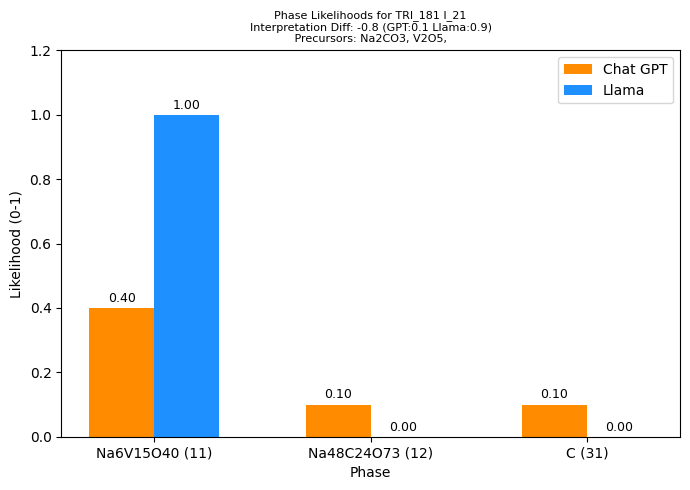

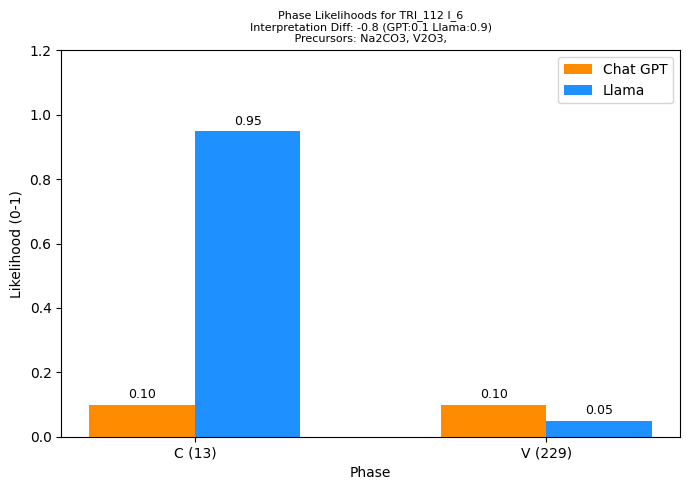

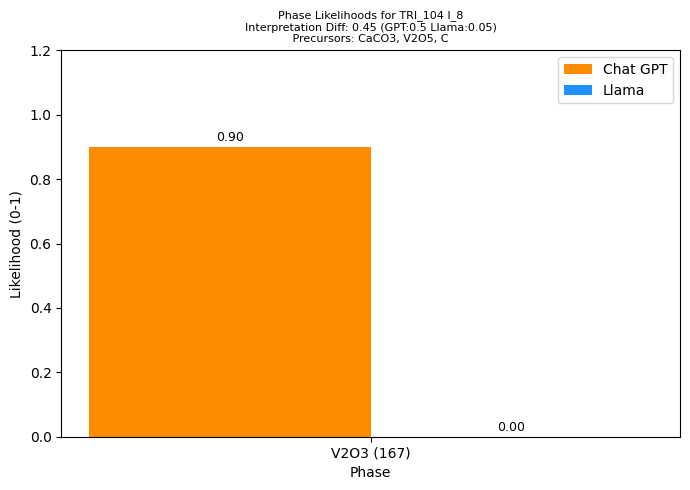

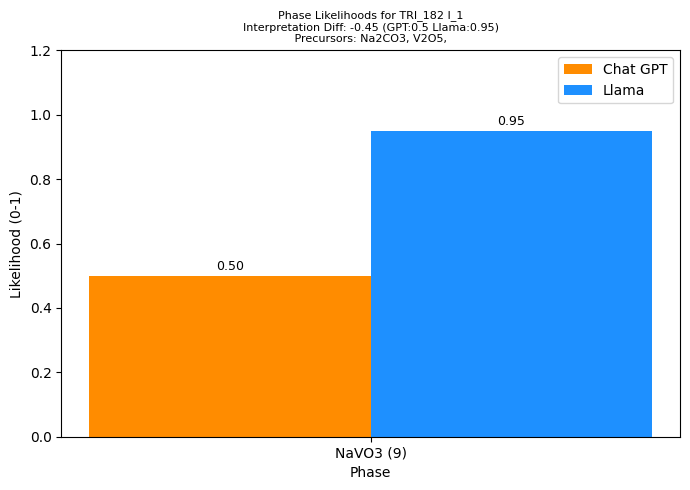

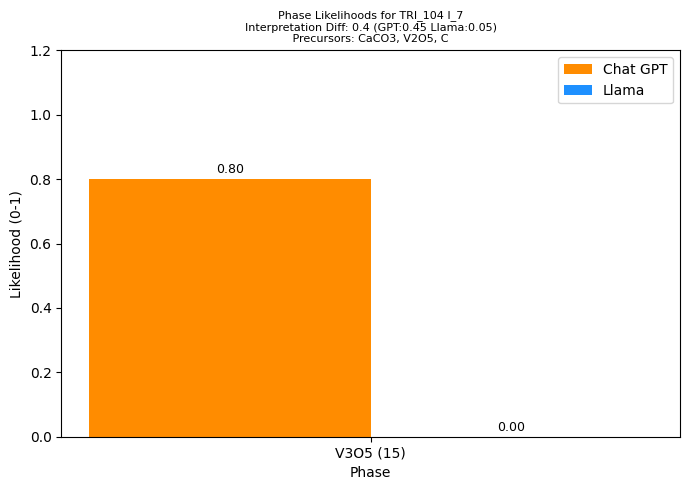

In [201]:
for i in range(len(interp1)):
    run = runs1[i]
    interpret = interp1[i]
    llama_interpret = llama_vals1[i]
    gpt_interpret = chatgpt_vals1[i]
    diff = round(diff1[i],2)
    run_interpret = json_file[run][interpret]
    gpt_phase_likelihood = run_interpret["LLM_phases_likelihood"]
    llama_phase_likelihood = run_interpret["LLM_phases_likelihood_llama"]
    labels = list(llama_phase_likelihood.keys())
    gpt_likelihoods = list(gpt_phase_likelihood.values())
    llama_likelihoods = list(llama_phase_likelihood.values())
    synth = json_file[run]["Synth_Conditions"]
    input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'

    x = np.arange(len(labels))
    width = 0.3

    plt.figure(figsize=(7,5))

    plt.bar(x-width/2,gpt_likelihoods,width, label='Chat GPT', color = "darkorange")
    plt.bar(x+width/2,llama_likelihoods,width,label='Llama', color = "dodgerblue")

    plt.title(f'Phase Likelihoods for {run} {interpret}\nInterpretation Diff: {diff} (GPT:{gpt_interpret} Llama:{llama_interpret})\n Precursors: {input_phases}', fontsize=8)
    plt.ylabel('Likelihood (0-1)')
    plt.xlabel('Phase')
    labels = [phase_key_to_short(label) for label in labels]
    plt.xticks(x, labels, rotation=0, ha='center')
    plt.ylim(0, 1.2)
    
    for j, val in enumerate(gpt_likelihoods):
        plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    for j, val in enumerate(llama_likelihoods):
        plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    plt.legend()
    plt.tight_layout()
    plt.show


In [203]:
print("P2\u2081/c (SG 15) is a known polymorph of V\u2083O\u2085. Its formation is plausible under reducing conditions.")

P2₁/c (SG 15) is a known polymorph of V₃O₅. Its formation is plausible under reducing conditions.


In [222]:
import numpy as np

def weighted_agreement_score(set1, set2, p=4):
    set1 = np.array(set1)
    set2 = np.array(set2)
    disagreement = np.abs(set1 - set2) ** p
    mean_disagreement = np.mean(disagreement)
    score = 1 - mean_disagreement ** (1/p)
    return score
llama_interpretation_scores = []
gpt_interpretation_scores = []
for run in json_file: 
    if "Synth_Conditions" in json_file[run]:
        for interpret in json_file[run]:
            if interpret != "Synth_Conditions":
                llama_interpretation_scores.append(json_file[run][interpret]["LLM_interpretation_likelihood_llama"])
                gpt_interpretation_scores.append(json_file[run][interpret]["LLM_interpretation_likelihood"])
agreement = weighted_agreement_score(llama_interpretation_scores,gpt_interpretation_scores,p=8)
agreement = round(agreement,3)

print(f"Llama-ChatGPT Weighted Interpretation Agreement Score: {agreement}")

Llama-ChatGPT Weighted Interpretation Agreement Score: 0.505


In [275]:
json_file_path1 = "Data/interpretations_llm_v1_llama1.json"
json_file_path2 = "Data/interpretations_llm_v1_llama2.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
list_agreements = []
agreement_score = []
for run in json_file: 
    if "Synth_Conditions" in json_file[run]:
        llama_scores = []
        gpt_scores = []
        for interpret in json_file[run]:
            if interpret != "Synth_Conditions":
                llama_scores.append(json_file1[run][interpret]["LLM_interpretation_likelihood_llama"])
                gpt_scores.append(json_file1[run][interpret]["LLM_interpretation_likelihood"])
    if llama_scores and gpt_scores: 
        run_interpret_agreement = round(weighted_agreement_score(llama_scores,gpt_scores,p=4),3)
        run_interpret_num = len(json_file[run].keys())-1
        agreement_score.append(run_interpret_agreement)
        list_agreements.append(f"{run} ({run_interpret_num} Interpretations): {run_interpret_agreement}")
ranked_agreement = zip(agreement_score,list_agreements)
ranked_agreement = sorted(ranked_agreement)
print("Weighted Agreement Scores by Sample:")
for i in ranked_agreement:
    print(i[1])

Weighted Agreement Scores by Sample:
TRI_181 (28 Interpretations): 0.535
TRI_182 (2 Interpretations): 0.618
TRI_63 (3 Interpretations): 0.618
TRI_104 (8 Interpretations): 0.72
TRI_112 (10 Interpretations): 0.738
TRI_84 (4 Interpretations): 0.75
TRI_126 (4 Interpretations): 0.765
TRI_197 (4 Interpretations): 0.765
TRI_106 (4 Interpretations): 0.775
TRI_39 (4 Interpretations): 0.789
TRI_31 (9 Interpretations): 0.807
TRI_172 (9 Interpretations): 0.815
TRI_30 (5 Interpretations): 0.92
TRI_28 (2 Interpretations): 0.941


I_1: ChatGPT: 0.25 - The interpretation includes a phase (Li14V43O114) that is not well-documented or expected under the given conditions, and LiV3O8 is present in a very minor fraction. The overall composition does not align well with the target LiV3O4, reducing plausibility.
I_1: llama: 0.7 - This interpretation includes plausible phases, but the dominance of Li14V43O114 and presence of LiV3O8 need further evaluation based on thermodynamic stability and reaction kinetics.
I_2: ChatGPT: 0.3 - The interpretation suggests a single phase, LiV3O8, which is less likely to be the dominant product under the synthesis conditions aimed at LiV3O4. The absence of other phases or unreacted precursors reduces the credibility of this interpretation.
I_2: llama: 0.6 - While LiV3O8 is a plausible product, the interpretation's completeness and the absence of other expected phases (e.g., unreacted Li2CO3 or V2O5) reduce its likelihood.
I_3: ChatGPT: 0.15 - This interpretation suggests a single phase, L

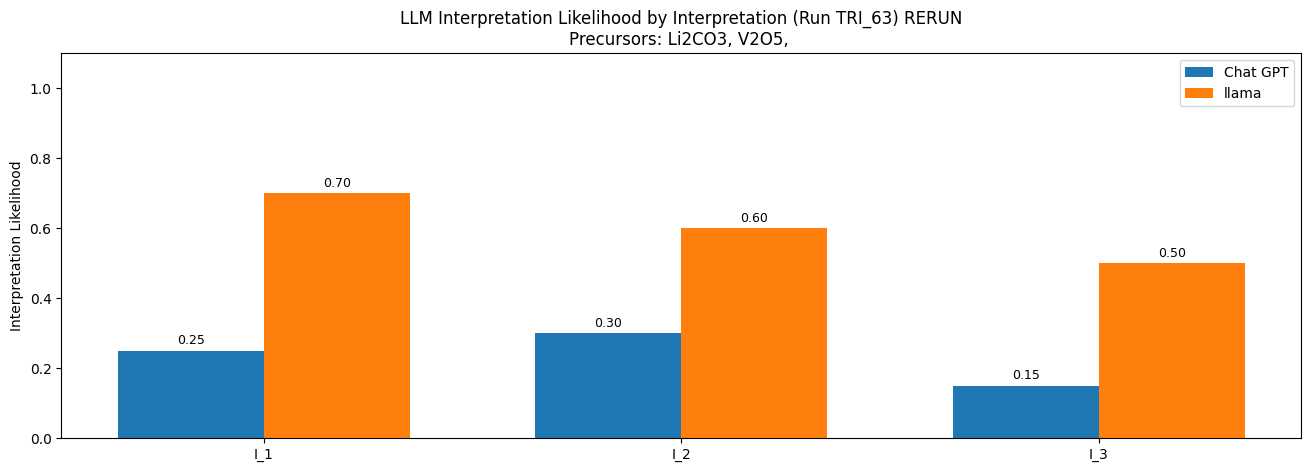

In [294]:
# for run in json_file:
#     if "Synth_Conditions" in json_file[run]:
run = "TRI_63"
Interpretation = []
ChatGpt_1 = []
llama_1 = []
for interpret in json_file[run]:
    if interpret not in ["Synth_Conditions"]:
        chatgpt_val = json_file[run][interpret].get("LLM_interpretation_likelihood")
        chatgpt_exp = json_file[run][interpret].get("LLM_interpretation_explanation")
        llama_val = json_file[run][interpret].get("LLM_interpretation_likelihood_llama")
        llama_exp = json_file[run][interpret].get("LLM_interpretation_explanation_llama")
        #print out the scores and explanations for each interpretation
        print(f"{interpret}: ChatGPT: {chatgpt_val} - {chatgpt_exp}")
        print(f"{interpret}: llama: {llama_val} - {llama_exp}") 
        

        if chatgpt_val is not None and llama_val is not None:
            try:
                ChatGpt_1.append(float(chatgpt_val))
                llama_1.append(float(llama_val))
                Interpretation.append(interpret)
            except ValueError:
                print(f"Non-numeric value in run {run}, interpretation {interpret}: {chatgpt_val}, {llama_val}")
synth = json_file[run]["Synth_Conditions"]
input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'


x1 = np.arange(len(Interpretation))
width = 0.35

plt.figure(figsize=(16,5))
plt.bar(x1 - width/2, ChatGpt_1, width, label='Chat GPT')
plt.bar(x1 + width/2, llama_1, width, label='llama')
plt.ylabel('Interpretation Likelihood')
plt.title(f'LLM Interpretation Likelihood by Interpretation (Run {run})\nPrecursors: {input_phases}')
plt.xticks(x1,Interpretation, rotation=0, ha='center')
for j, val in enumerate(ChatGpt_1):
    plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
for j, val in enumerate(llama_1):
    plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout
plt.show()

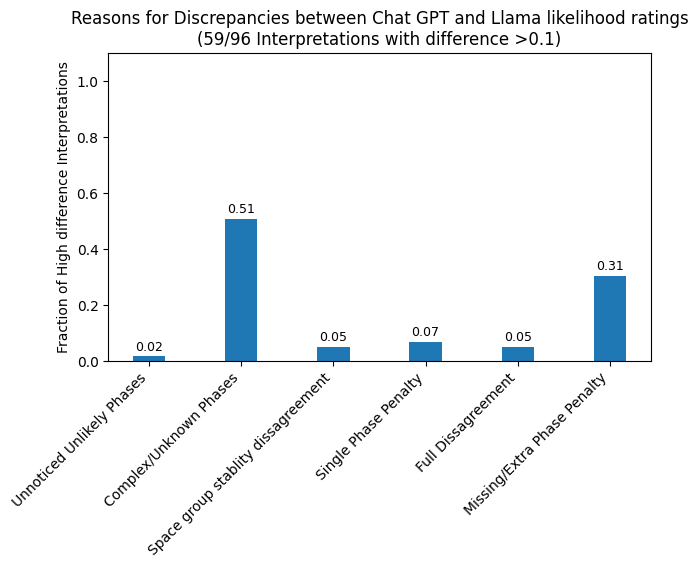

In [344]:
explain = ["Unnoticed Unlikely Phases","Complex/Unknown Phases","Space group stablity dissagreement","Single Phase Penalty","Full Dissagreement","Missing/Extra Phase Penalty"]
number = [1,30,3,4,3,18]
total = 0
for i in number:
    total += i 
number = [i/total for i in number]
x1 = np.arange(len(explain))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x1, number, width)
plt.ylabel('Fraction of High difference Interpretations')
plt.title(f'Reasons for Discrepancies between Chat GPT and Llama likelihood ratings\n({total}/96 Interpretations with difference >0.1)')
plt.xticks(x1,explain, rotation=45, ha='right',fontsize = 10)
for j, val in enumerate(number):
    plt.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)

plt.ylim(0,1.1)
plt.tight_layout
plt.show()

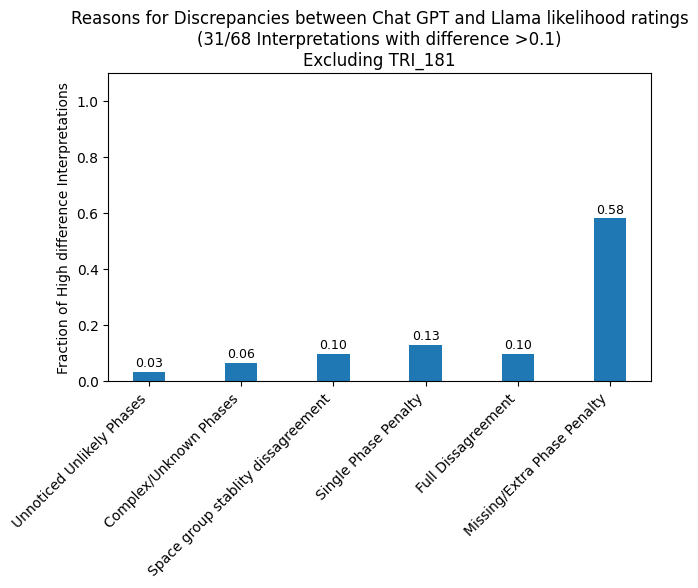

In [343]:
explain = ["Unnoticed Unlikely Phases","Complex/Unknown Phases","Space group stablity dissagreement","Single Phase Penalty","Full Dissagreement","Missing/Extra Phase Penalty"]
number = [1,2,3,4,3,18]
total = 0
for i in number:
    total += i 
number = [i/total for i in number]
x1 = np.arange(len(explain))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x1, number, width)
plt.ylabel('Fraction of High difference Interpretations')
plt.title(f'Reasons for Discrepancies between Chat GPT and Llama likelihood ratings\n({total}/68 Interpretations with difference >0.1)\nExcluding TRI_181')
plt.xticks(x1,explain, rotation=45, ha='right',fontsize = 10)
for j, val in enumerate(number):
    plt.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)

plt.ylim(0,1.1)
plt.tight_layout
plt.show()

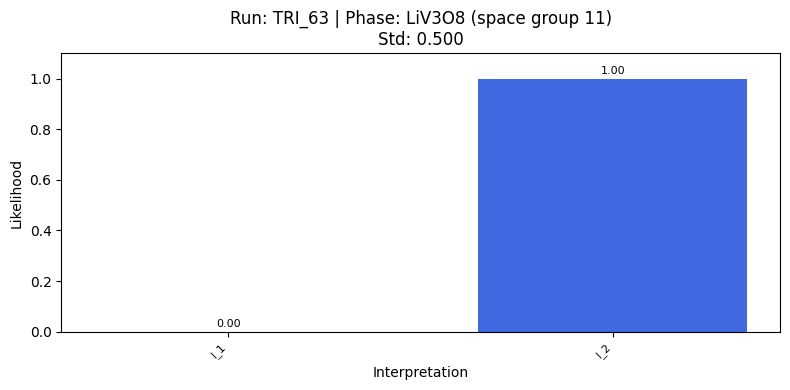

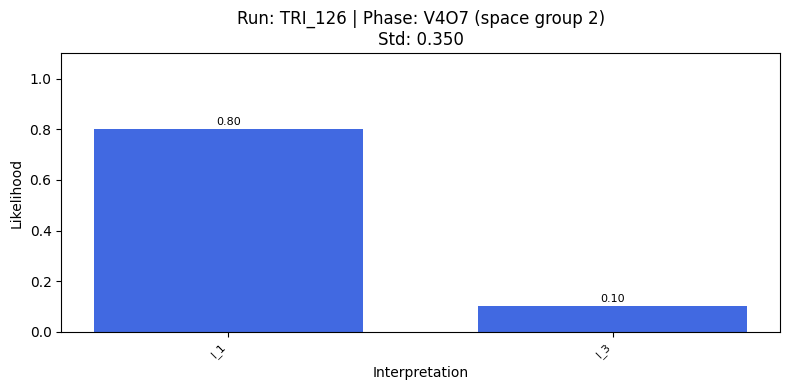

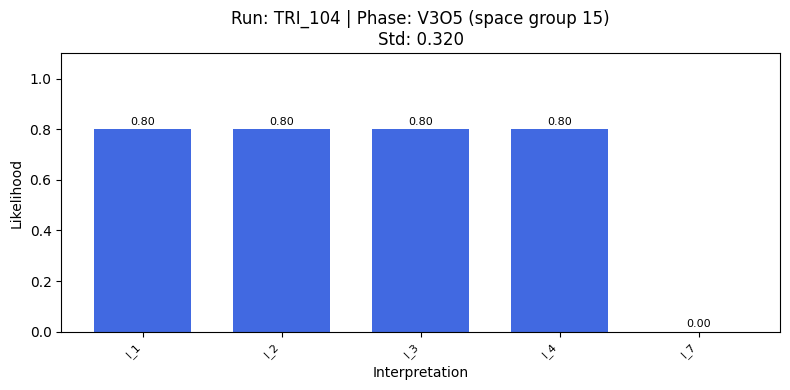

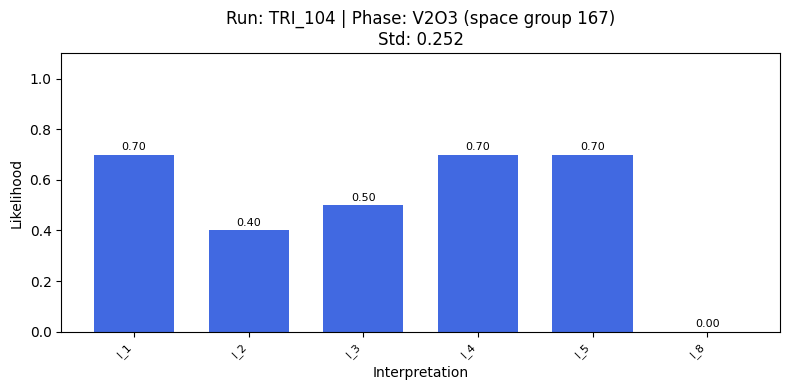

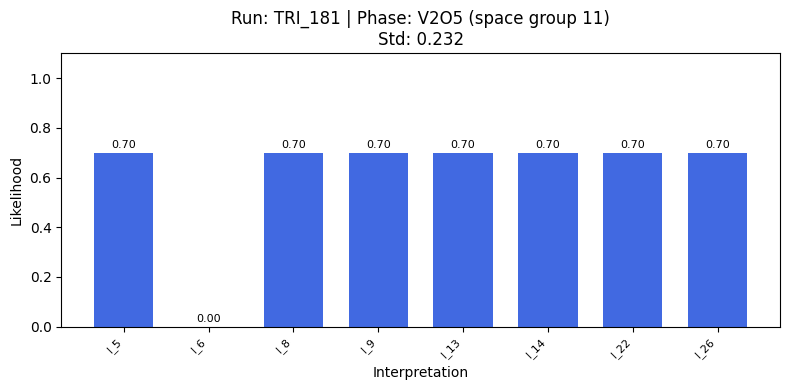

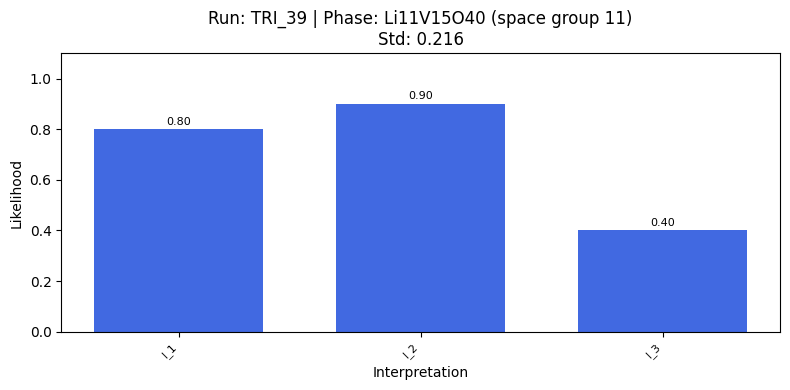

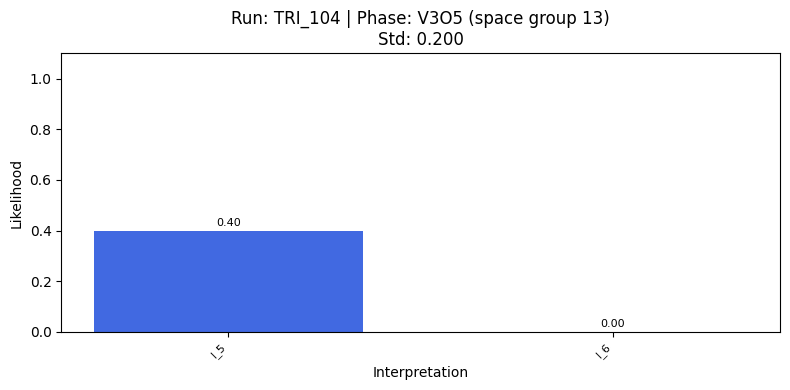

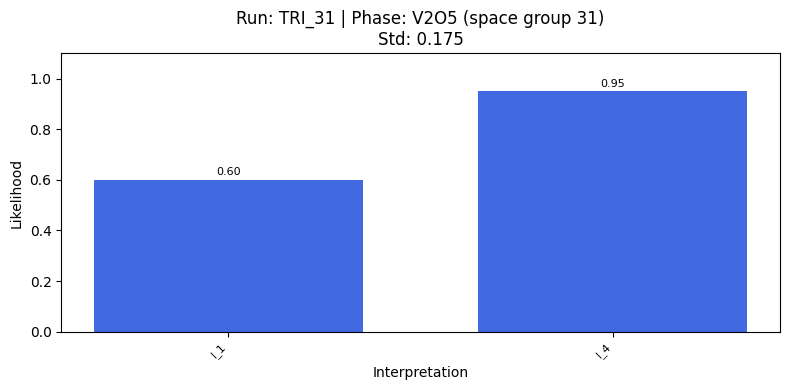

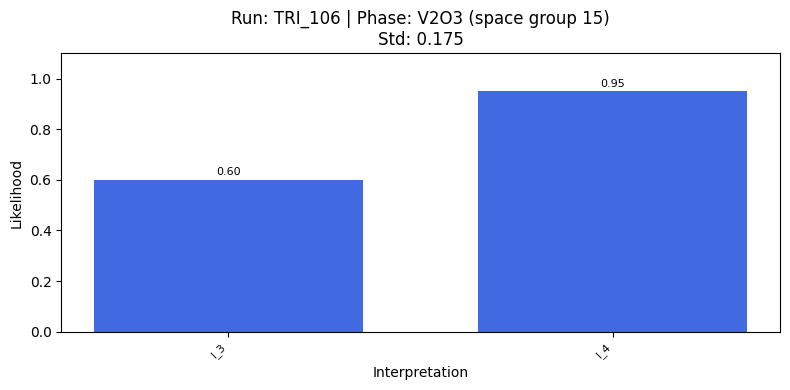

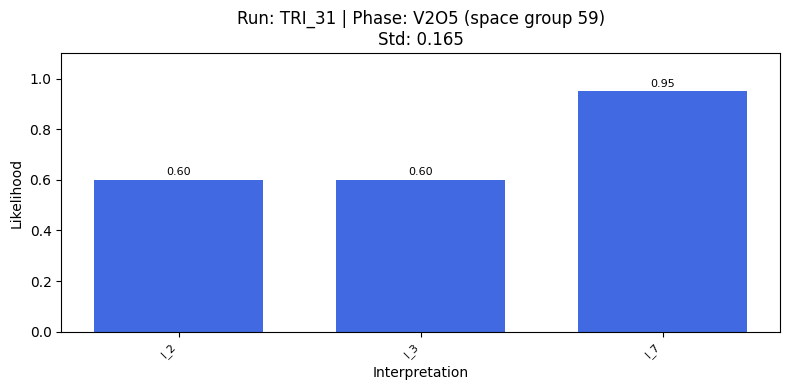

In [330]:
import matplotlib.pyplot as plt
import numpy as np
json_file_path = "Data/interpretations_llm_v1_llama1.json"
json_file = load_json(json_file_path)
global_phase_std = []
global_likelihood_dict = {}
for run in json_file:
    if "Synth_Conditions" not in json_file[run]:
        continue

    # 1. Collect all phases and their likelihoods for this run
    phase_likelihoods_dict = {}  # {phase: [(interpretation, likelihood), ...]}
    for interp in json_file[run]:
        if interp.startswith("I_"):
            phase_likelihoods = json_file[run][interp].get("LLM_phases_likelihood_llama", {})
            for phase, likelihood in phase_likelihoods.items():
                if phase not in phase_likelihoods_dict:
                    phase_likelihoods_dict[phase] = []
                phase_likelihoods_dict[phase].append((interp, likelihood))

    # 2. Compute std for each phase (within this run)
    phase_std = []
    for phase, values in phase_likelihoods_dict.items():
        likelihoods = [v[1] for v in values]
        if len(likelihoods) > 1:
            std = np.std(likelihoods)
            phase_std.append((phase, std, run))
    global_phase_std.extend(phase_std)
    global_likelihood_dict[run] = phase_likelihoods_dict
    

# 3. Select top 10 phases by std for all runs
top_phases = sorted(global_phase_std, key=lambda x: x[1], reverse=True)[:10]

# 4. Plot a bar graph for each selected phase
for phase, std, run in top_phases:
    values = global_likelihood_dict[run][phase]
    x_labels = [interp for interp, _ in values]
    y = [likelihood for _, likelihood in values]
    x = np.arange(len(x_labels))

    plt.figure(figsize=(max(8, len(x_labels)//2), 4))
    plt.bar(x, y, color='royalblue', width=0.7)
    plt.ylabel('Likelihood')
    plt.xlabel('Interpretation')
    plt.title(f'Run: {run} | Phase: {phase}\nStd: {std:.3f}', fontsize=12)
    plt.ylim(0, 1.1)
    plt.xticks(x, x_labels, rotation=45, ha='right', fontsize=8)
    for j, val in enumerate(y):
        plt.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8, rotation=0, clip_on=True)
    plt.tight_layout()
    plt.show()

In [ ]:
json_file_path1 = "Data/interpretations_llm_v1_llama1.json"
json_file_path2 = "Data/interpretations_llm_v4_llama8.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
list_agreements = []
agreement_score = []
for run in json_file: 
    if "Synth_Conditions" in json_file[run]:
        llama_scores = []
        gpt_scores = []
        for interpret in json_file[run]:
            if interpret != "Synth_Conditions":
                llama_scores.append(json_file1[run][interpret]["LLM_interpretation_likelihood_llama"])
                gpt_scores.append(json_file2[run][interpret]["LLM_interpretation_likelihood_llama"])
    if llama_scores and gpt_scores: 
        run_interpret_agreement = round(weighted_agreement_score(llama_scores,gpt_scores,p=4),3)
        run_interpret_num = len(json_file[run].keys())-1
        agreement_score.append(run_interpret_agreement)
        list_agreements.append(f"{run} ({run_interpret_num} Interpretations): {run_interpret_agreement}")
ranked_agreement = zip(agreement_score,list_agreements)
ranked_agreement = sorted(ranked_agreement)
print("Weighted Agreement Scores by Sample:")
for i in ranked_agreement:
    print(i[1])

KeyError: 'LLM_interpretation_likelihood_llama'

I_1: llama1: 0.65 - This interpretation includes plausible vanadium oxide phases, but the absence of calcium-containing phases is notable. The composition balance score of 0.593 is moderate.
I_1: llama2: 0.65 - This interpretation includes plausible vanadium oxide phases, but the absence of calcium-containing phases is notable. The composition balance score of 0.593 indicates potential elemental imbalances.
I_2: llama1: 0.85 - This interpretation includes calcium-containing phases, which are expected given the precursors. The composition balance score of 1.0 is excellent.
I_2: llama2: 0.85 - This interpretation is more plausible due to the inclusion of calcium-containing phases. The composition balance score of 1.0 supports this interpretation.
I_3: llama1: 0.8 - This interpretation includes plausible phases, including a calcium-vanadium oxide. The composition balance score of 0.931 is high.
I_3: llama2: 0.8 - This interpretation includes plausible phases, and the presence of CaV₃O₇ is

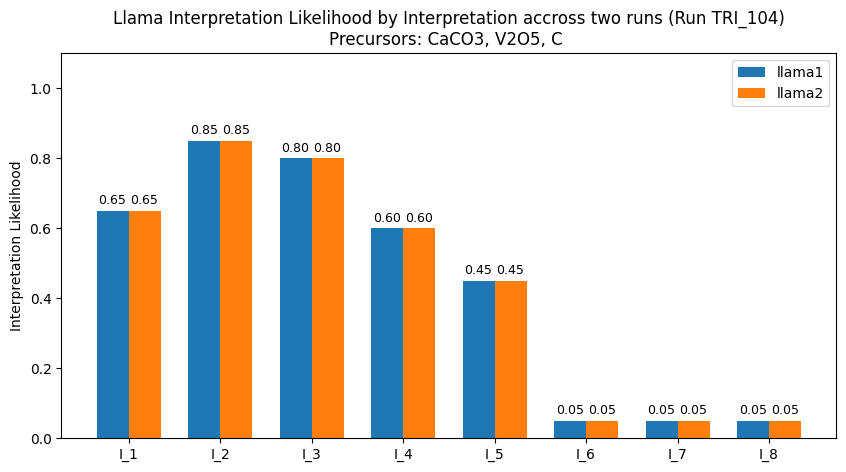

In [24]:
# for run in json_file:
#     if "Synth_Conditions" in json_file[run]:
json_file_path1 = "Data/interpretations_llm_v1_llama1.json"
json_file_path2 = "Data/interpretations_llm_v4_llama8.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
run = "TRI_104"
Interpretation = []
llama1 = []
llama2 = []
for interpret in json_file[run]:
    if interpret not in ["Synth_Conditions"]:
        llama1_val = json_file1[run][interpret].get("LLM_interpretation_likelihood_llama")
        llama1_exp = json_file1[run][interpret].get("LLM_interpretation_explanation_llama")
        llama2_val = json_file2[run][interpret].get("LLM_interpretation_likelihood_llama")
        llama2_exp = json_file2[run][interpret].get("LLM_interpretation_explanation_llama")
        #print out the scores and explanations for each interpretation
        print(f"{interpret}: llama1: {llama1_val} - {llama1_exp}")
        print(f"{interpret}: llama2: {llama2_val} - {llama2_exp}") 
        

        if llama1_val is not None and llama2_val is not None:
            try:
                llama1.append(float(llama1_val))
                llama2.append(float(llama2_val))
                Interpretation.append(interpret)
            except ValueError:
                print(f"Non-numeric value in run {run}, interpretation {interpret}: {llama1_val}, {llama2_val}")
synth = json_file1[run]["Synth_Conditions"]
input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'


x1 = np.arange(len(Interpretation))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x1 - width/2, llama1, width, label='llama1')
plt.bar(x1 + width/2, llama2, width, label='llama2')
plt.ylabel('Interpretation Likelihood')
plt.title(f'Llama Interpretation Likelihood by Interpretation accross two runs (Run {run})\nPrecursors: {input_phases}')
plt.xticks(x1,Interpretation, rotation=0, ha='center')
for j, val in enumerate(llama1):
    plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
for j, val in enumerate(llama2):
    plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout
plt.show()

V3O5 (15)
Chat GPT: "V3O5 is a plausible phase under reducing conditions, such as those provided by carbon and argon atmosphere. Space group 15 is consistent with known structures."
Llama: "P2₁/c (SG 15) is a known polymorph of V₃O₅. Its formation is plausible under reducing conditions."
V2O3 (167)
Chat GPT: "V2O3 is a stable phase under reducing conditions and is likely to form given the presence of carbon and argon atmosphere."
Llama: "R-3c (SG 167) is a stable structure for V₂O₃. It may form under reducing conditions."
V6O13 (69)
Chat GPT: "V6O13 can form under reducing conditions but is less stable than V2O3 and V3O5. It may be present due to kinetic factors."
Llama: "This phase is less common and may form under specific conditions. Its presence at 8% weight fraction is plausible."
V5O9 (2)
Chat GPT: "V5O9 is less common and may form under specific conditions. Its presence is plausible but less likely than V2O3 and V3O5."
Llama: "This phase is also less common. Its presence at 22% 

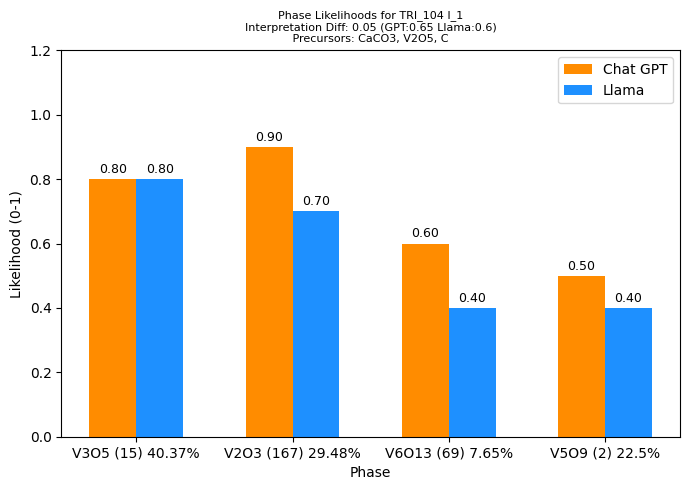

In [ ]:
run = "TRI_104"
interpret = "I_1"
json_file_path1 = "Data/interpretations_llm_v1_llama1.json"
json_file_path2 = "Data/interpretations_llm_v1_llama1.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
llama_interpret = json_file1[run][interpret]["LLM_interpretation_likelihood_llama"]
gpt_interpret = json_file2[run][interpret]["LLM_interpretation_likelihood"]
diff = round(gpt_interpret - llama_interpret,2)
labels = []
run_interpret1 = json_file1[run][interpret]
run_interpret2 = json_file2[run][interpret]
gpt_phase_likelihood = run_interpret1["LLM_phases_likelihood"]
llama_phase_likelihood = run_interpret2["LLM_phases_likelihood_llama"]
labels_only = list(llama_phase_likelihood.keys())
for i in range(len(labels_only)):
    wf = run_interpret1["weight_fraction"]
    labels.append(f"{phase_key_to_short(labels_only[i])} {round(wf[i],2)}%")

gpt_likelihoods = list(gpt_phase_likelihood.values())
llama_likelihoods = list(llama_phase_likelihood.values())
synth = json_file1[run]["Synth_Conditions"]
input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'

x = np.arange(len(labels))
width = 0.3

plt.figure(figsize=(7,5))

plt.bar(x-width/2,gpt_likelihoods,width, label='Chat GPT', color = "darkorange")
plt.bar(x+width/2,llama_likelihoods,width,label='Llama', color = "dodgerblue")

plt.title(f'Phase Likelihoods for {run} {interpret}\nInterpretation Diff: {diff} (GPT:{gpt_interpret} Llama:{llama_interpret})\n Precursors: {input_phases}', fontsize=8)
plt.ylabel('Likelihood (0-1)')
plt.xlabel('Phase')
labels = [phase_key_to_short(label) for label in labels]
plt.xticks(x, labels, rotation=0, ha='center')
plt.ylim(0, 1.2)

for j, val in enumerate(gpt_likelihoods):
    plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
for j, val in enumerate(llama_likelihoods):
    plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
plt.legend()
plt.tight_layout()

phase_exp1 = run_interpret1["LLM_phases_explanation"]
phase_exp2 = run_interpret2["LLM_phases_explanation_llama"]
for label in labels_only:
    print(phase_key_to_short(label))
    print(f'Chat GPT: "{phase_exp1[label]}"')
    print(f'Llama: "{phase_exp2[label]}"')
print("")
print(f'Chat GPT Interpretation: "{run_interpret1["LLM_interpretation_explanation_llama"]}"')
print(f'Llama Interpretation: "{run_interpret1["LLM_interpretation_explanation_llama"]}"')
    
plt.show()

